In [24]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from transformers import Trainer, TrainingArguments, AutoModelForImageClassification, CLIPVisionModel, CLIPModel, CLIPProcessor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from tqdm import tqdm

# Data Visualization/Pre-Processing

In [26]:
data_path = 'data/archive/compressed_dataset/' # change this according to where you put your data
batch_size = 32

In [28]:
# transform images to tensors for training compatibility
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# create a datset object and loads images into it then put it into a dataloader to be compatible with training
image_dataset = datasets.ImageFolder(os.path.join(data_path), transform)
class_names = image_dataset.classes
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

# split train and validation sets (80:20)
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(image_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

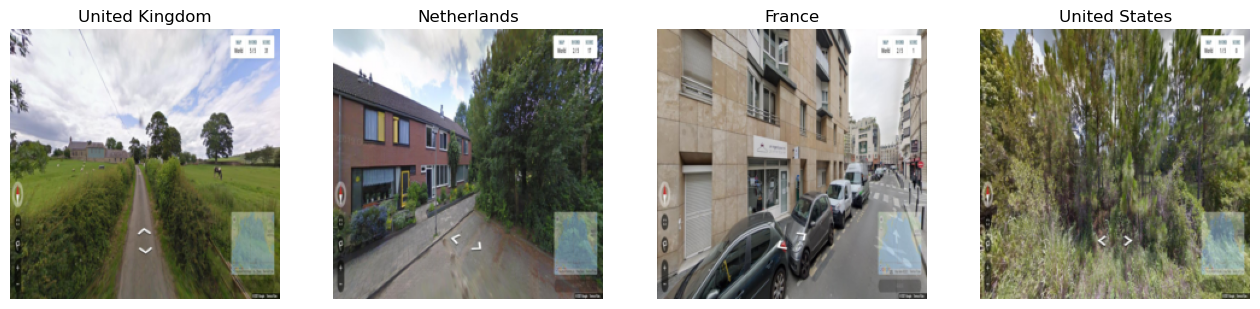

In [13]:
# Retrieve images and labels
images, labels = next(iter(train_loader))

# Normalize images
images -= images.min()
images /= images.max()

# Display images
fig = plt.figure(figsize=(16,10))
for i in range(4):
  fig.add_subplot(1, 4, i+1)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.title(class_names[labels[i]])
  plt.axis('off')

Create Heatmap

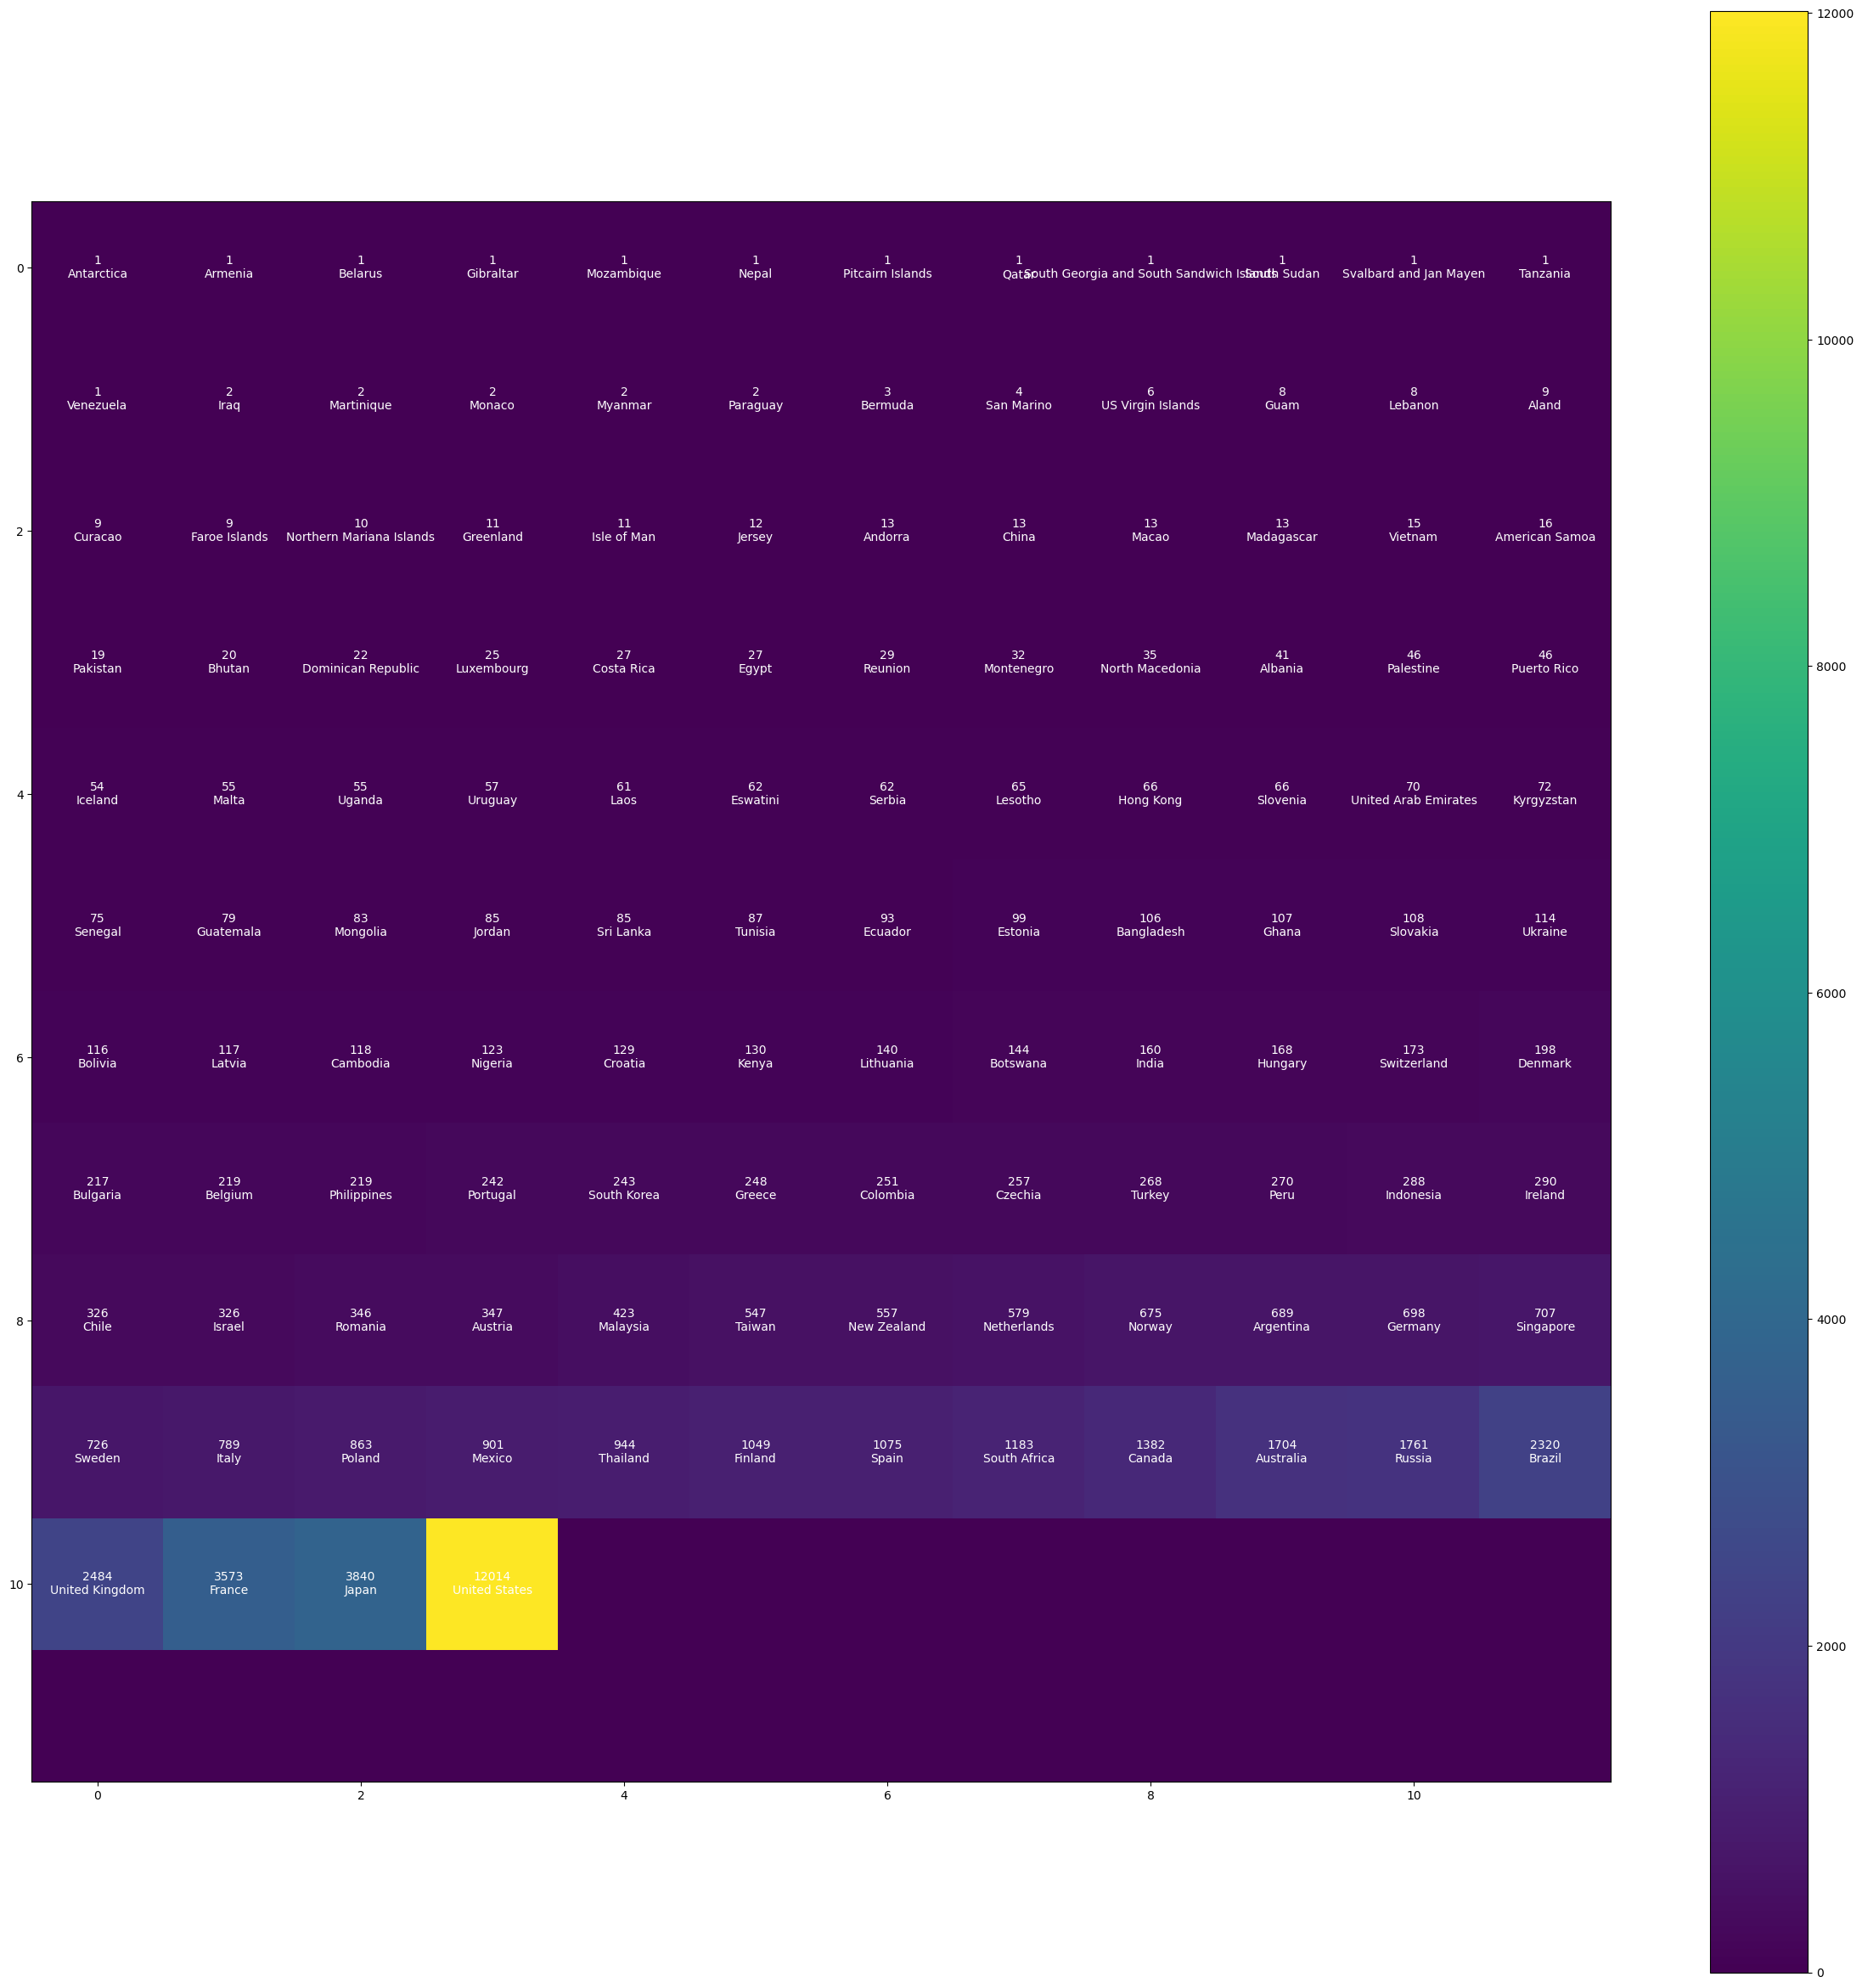

In [32]:
from math import sqrt, ceil
import numpy as np
import matplotlib.pyplot as plt
import pathlib

data_path = pathlib.Path(data_path)
def count_samples(path):
    return path.name, len(list(path.glob('*')))

zipped_data_distribution = list(map(count_samples, data_path.glob('*/')))

# Sort the zipped_data_distribution based on the number of pictures
zipped_data_distribution.sort(key=lambda x: x[1])

# Extract labels and numbers
labels = [item[0] for item in zipped_data_distribution]
numbers = [item[1] for item in zipped_data_distribution]
grid_size = ceil(sqrt(len(labels)))

grid = np.zeros((grid_size, grid_size), dtype=int)
for i, num in enumerate(numbers):
    row = i // grid_size
    col = i % grid_size
    grid[row, col] = num
 
# Create the heatmap
plt.figure(figsize=(30, 30))  # Set the size of the figure (width, height)
plt.imshow(grid, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add color bar

# Add annotations
for i in range(grid_size):
    for j in range(grid_size):
        if(i*grid_size+j<len(labels)):
            plt.text(j, i, f'{grid[i, j]}\n{labels[i*grid_size+j]}', ha='center', va='center', color='white')

plt.show()





# Training

In [ ]:
learning_rate = 1e-3

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters, lr=learning_rate, betas=(0.9,0.98), eps=1e-6, weight_decay=0.2)

img_loss = nn.CrossEntropyLoss()
txt_loss = nn.CrossEntropyLoss()

epochs = 10

for epoch in range(epochs):
    pbar = tqdm(train_loader, total=len(train_loader))
    
    for batch in pbar:
        optimizer.zero_grad()
        images,texts = batch 
        images= images.to(device)
        texts = texts.to(device)
        logits_per_image, logits_per_text = model(images, texts)
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (img_loss(logits_per_image,ground_truth) + txt_loss(logits_per_text,ground_truth))/2
        total_loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch}/{epochs}, Loss: {total_loss.item():.4f}")
    # for inputs, target in train_loader:
    #     inputs, targets = inputs.to(device), targets.to(device)
    #     optimizer.zero_grad()
        